# TODO 1. 初步分析价格以及价格变化变量的统计特征，可视化

## 数据基本分析

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt # 是matplotlib的子包
import os
if os.name == 'posix': # 如果系统是mac或者linux
    plt.rcParams['font.sans-serif'] = ['Songti SC'] #中文字体为宋体
else:
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 在windows系统下显示微软雅黑
plt.rcParams['axes.unicode_minus'] = False # 负号用 ASCII 编码的-显示，而不是unicode的 U+2212
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)


In [3]:
def read_data(filename):
    fn1=pd.read_csv(f'../dataset/{filename}_1.csv',parse_dates=[2])
    fn2=pd.read_csv(f'../dataset/{filename}_2.csv',parse_dates=[2])
    fn3=pd.read_csv(f'../dataset/{filename}_3.csv',parse_dates=[2])
    fn4=pd.read_csv(f'../dataset/{filename}_4.csv',parse_dates=[2])
    fn = pd.concat([fn1,fn2,fn3,fn4])
    return fn
fn1 = read_data(201405)
fn2 = read_data(201406)
len(fn1), len(fn2)

(617522, 665082)

In [4]:
# 跨天的数据deltaT改为nan
def DataProcess1(fn):
    _ = fn.copy()
    _ = _.loc[_['isBuy'] == 1,:] # 删去未交易数据 # _ = _[_['Price'] != _['Price'].shift(1)] # 删去价格相同的数据
    _.loc[:,'Time'] = pd.to_datetime(_['Time'])
    _['DeltaPrice'] = _['Price'].diff()
    _['DeltaPrice'] = _['DeltaPrice'].round(2)
    _['DeltaTick'] = _['DeltaPrice']/0.2
    _.loc[_['DeltaTick'] > 3,'DeltaTick'] = 3
    _.loc[_['DeltaTick'] < -3,'DeltaTick'] = -3
    _['DeltaTick'] = _['DeltaTick'].round(2)
    _['BidAskMid'] = (_['SP1'] + _['BP1'])/2
    _['BuySellIndicator'] = _.apply(lambda x: 1 if x['Price'] > x['BidAskMid'] else 0 if x['Price'] == x['BidAskMid'] else -1, axis=1)
    _['VolLag3'] = _['TotalVol'].shift(3)
    _.dropna(inplace=True)
    _['BidAskSpread'] = _['SP1'] - _['BP1']
    _['DeltaTime'] = _['Time'].diff()/np.timedelta64(1,'s')*1 # 交易之间相差的秒数的两倍（使得最小值是1）
    _.loc[(_['DeltaTime'] > 12 * 60 * 60 * 2),'DeltaTime'] = np.nan
    _.dropna(inplace=True)
    _.index = range(len(_))
    return _

fn1 = DataProcess1(fn1)
fn2 = DataProcess1(fn2)
print(len(fn1))

303278


In [5]:
def sttc1(fn,sttc_name):
    DataStat = pd.DataFrame({'Price':fn['Price'],'DeltaPrice':fn['DeltaPrice'],'DeltaTime':fn['DeltaTime'],'DeltaTick':fn['DeltaTick']})
    SumStat = pd.DataFrame(columns = pd.Index(DataStat.columns,name=f'sttc of {sttc_name}'))
    SumStat.loc['mean',:] = DataStat.mean()
    SumStat.loc['max',:] = DataStat.max()
    SumStat.loc['Q3',:] = DataStat.dropna().apply(lambda x: np.percentile(x, 75))
    SumStat.loc['median',:] = DataStat.median()
    SumStat.loc['Q1',:] = DataStat.dropna().apply(lambda x: np.percentile(x, 25))
    SumStat.loc['min',:] = DataStat.min()
    SumStat.loc['std',:] = DataStat.std()
    SumStat.loc['skew',:] = DataStat.skew()
    SumStat.loc['kurtosis',:] = DataStat.kurtosis()
    return SumStat
fn1Psttc = sttc1(fn1,'fn1')
fn1Psttc.to_csv('../result/fn1_price_sttc.csv')
fn1Psttc

sttc of fn1,Price,DeltaPrice,DeltaTime,DeltaTick
mean,2142.855986,0.000022,4.819156,0.005365
max,2185.8,13.6,64804.5,3.0
Q3,2158.0,0.0,1.5,0.0
median,2145.0,0.0,1.0,0.0
Q1,2130.8,0.0,0.5,0.0
min,2082.6,-11.6,0.0,-3.0
std,21.415104,0.159901,471.131893,0.712703
skew,-0.43668,-1.604113,135.974703,-0.382934
kurtosis,-0.447506,340.968897,18624.549362,3.19976


In [6]:
fn2Psttc = sttc1(fn2,'fn2')
fn2Psttc.to_csv('../result/fn2_price_sttc.csv')
fn2Psttc

sttc of fn2,Price,DeltaPrice,DeltaTime,DeltaTick
mean,2146.752396,-0.000021,4.55145,0.002777
max,2200.0,3.4,64803.0,3.0
Q3,2156.4,0.0,1.5,0.0
median,2146.6,0.0,1.0,0.0
Q1,2131.8,0.0,0.5,0.0
min,2112.4,-8.8,0.0,-3.0
std,18.523023,0.13562,453.6402,0.639797
skew,0.512731,-2.242666,141.17142,-0.409829
kurtosis,-0.518827,86.11002,20082.490798,3.649324


价格序列画图

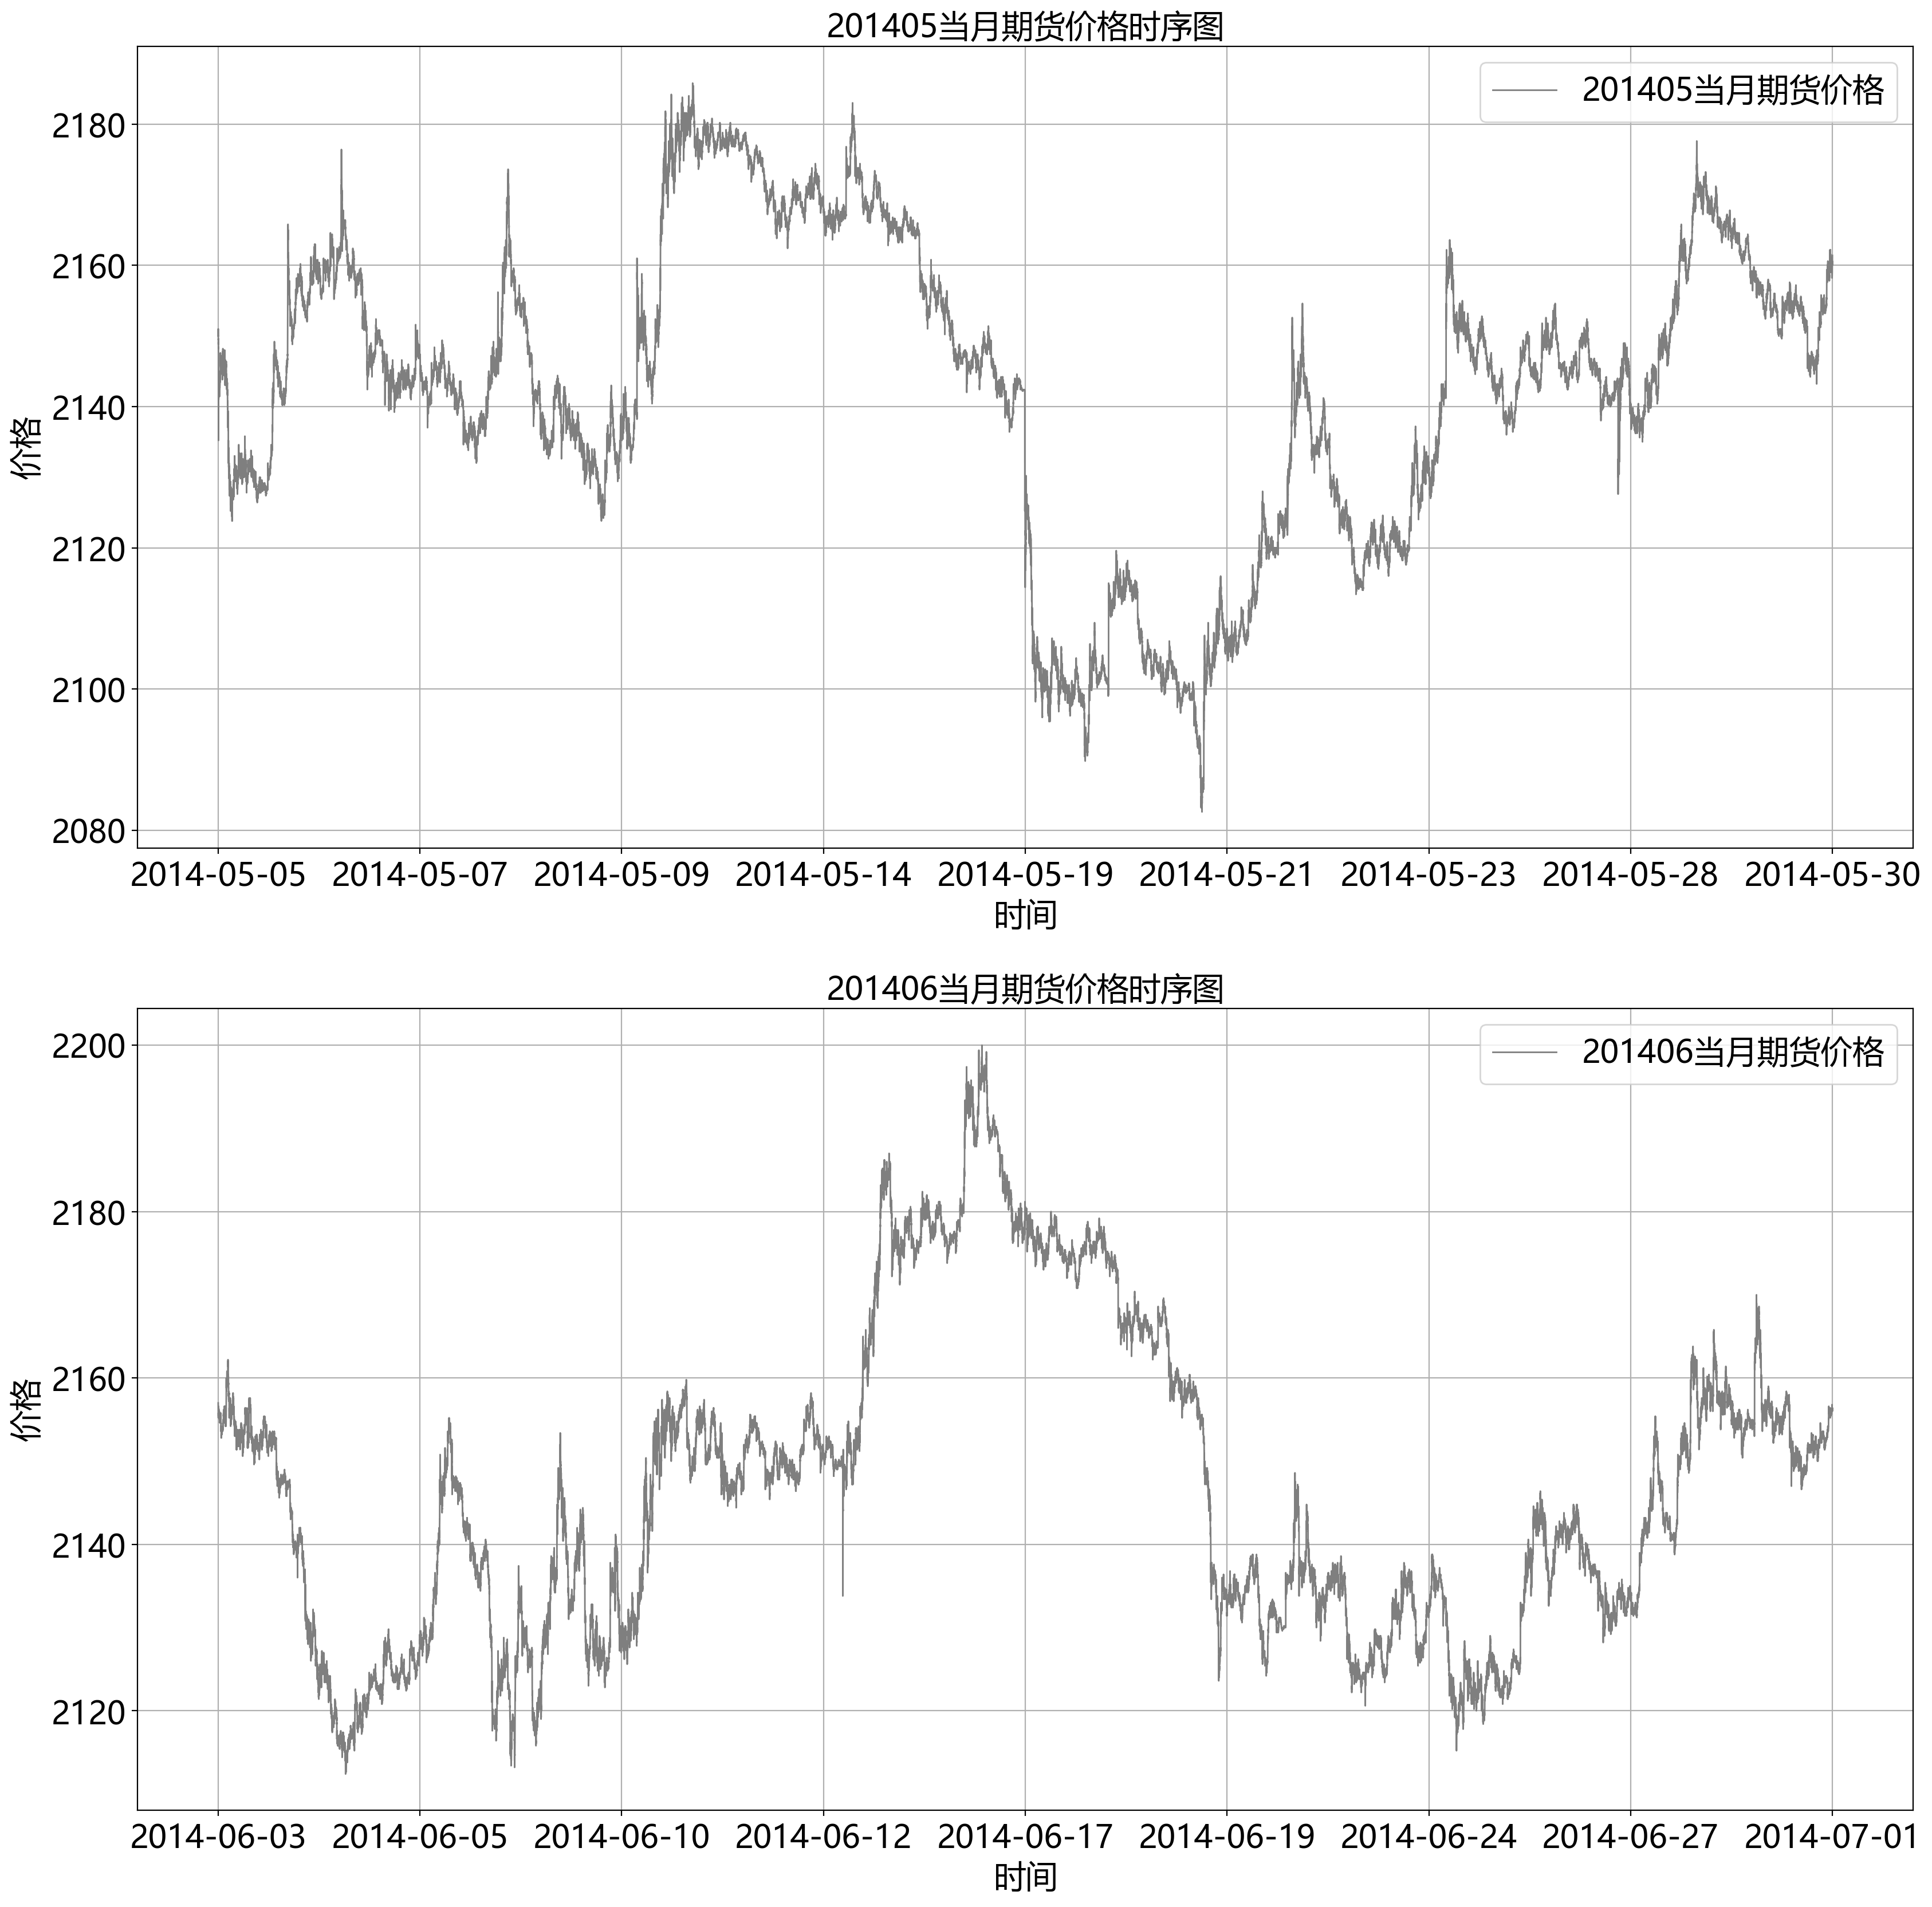

In [7]:
fig = plt.figure(figsize=(10 * 2,20), dpi=200) # 后面再加ax，不喜欢这种
fontsize = 20
x_label = '时间'
y_label = '价格'

ax = fig.add_subplot(2,1,1) 
x = fn1['Time']
y = fn1['Price']
ax.plot(range(len(x)),y, label = "201405当月期货价格", c='tab:grey',lw = 1)
ax.set_title('201405当月期货价格时序图',fontsize = fontsize)
ax.legend() 
ax.grid() 
ax.set_xticks( range(0,len(x),int(len(x)/8)) )
ax.set_xticklabels( [x[i].strftime('%Y-%m-%d') for i in ax.get_xticks()], rotation=0 )
ax.set_ylabel(y_label, fontsize = fontsize)
ax.set_xlabel(x_label, fontsize = fontsize)
ax.legend(fontsize = fontsize,loc = 'best')

ax = fig.add_subplot(2,1,2) 
x = fn2['Time']
y = fn2['Price']
ax.plot(range(len(x)),y, label = "201406当月期货价格", c='tab:grey',lw = 1)
ax.set_title('201406当月期货价格时序图',fontsize = fontsize)
ax.legend() 
ax.grid() 
ax.set_xticks( range(0,len(x),int(len(x)/8)-1) )
ax.set_xticklabels( [x[i].strftime('%Y-%m-%d') for i in ax.get_xticks()], rotation=0 )
ax.set_ylabel(y_label, fontsize = fontsize)
ax.set_xlabel(x_label, fontsize = fontsize)
ax.legend(fontsize = fontsize,loc = 'best')
plt.savefig('../result/Price_lineplot.jpg', bbox_inches = 'tight' , dpi=300, pad_inches = 0.0)
plt.show()

价格

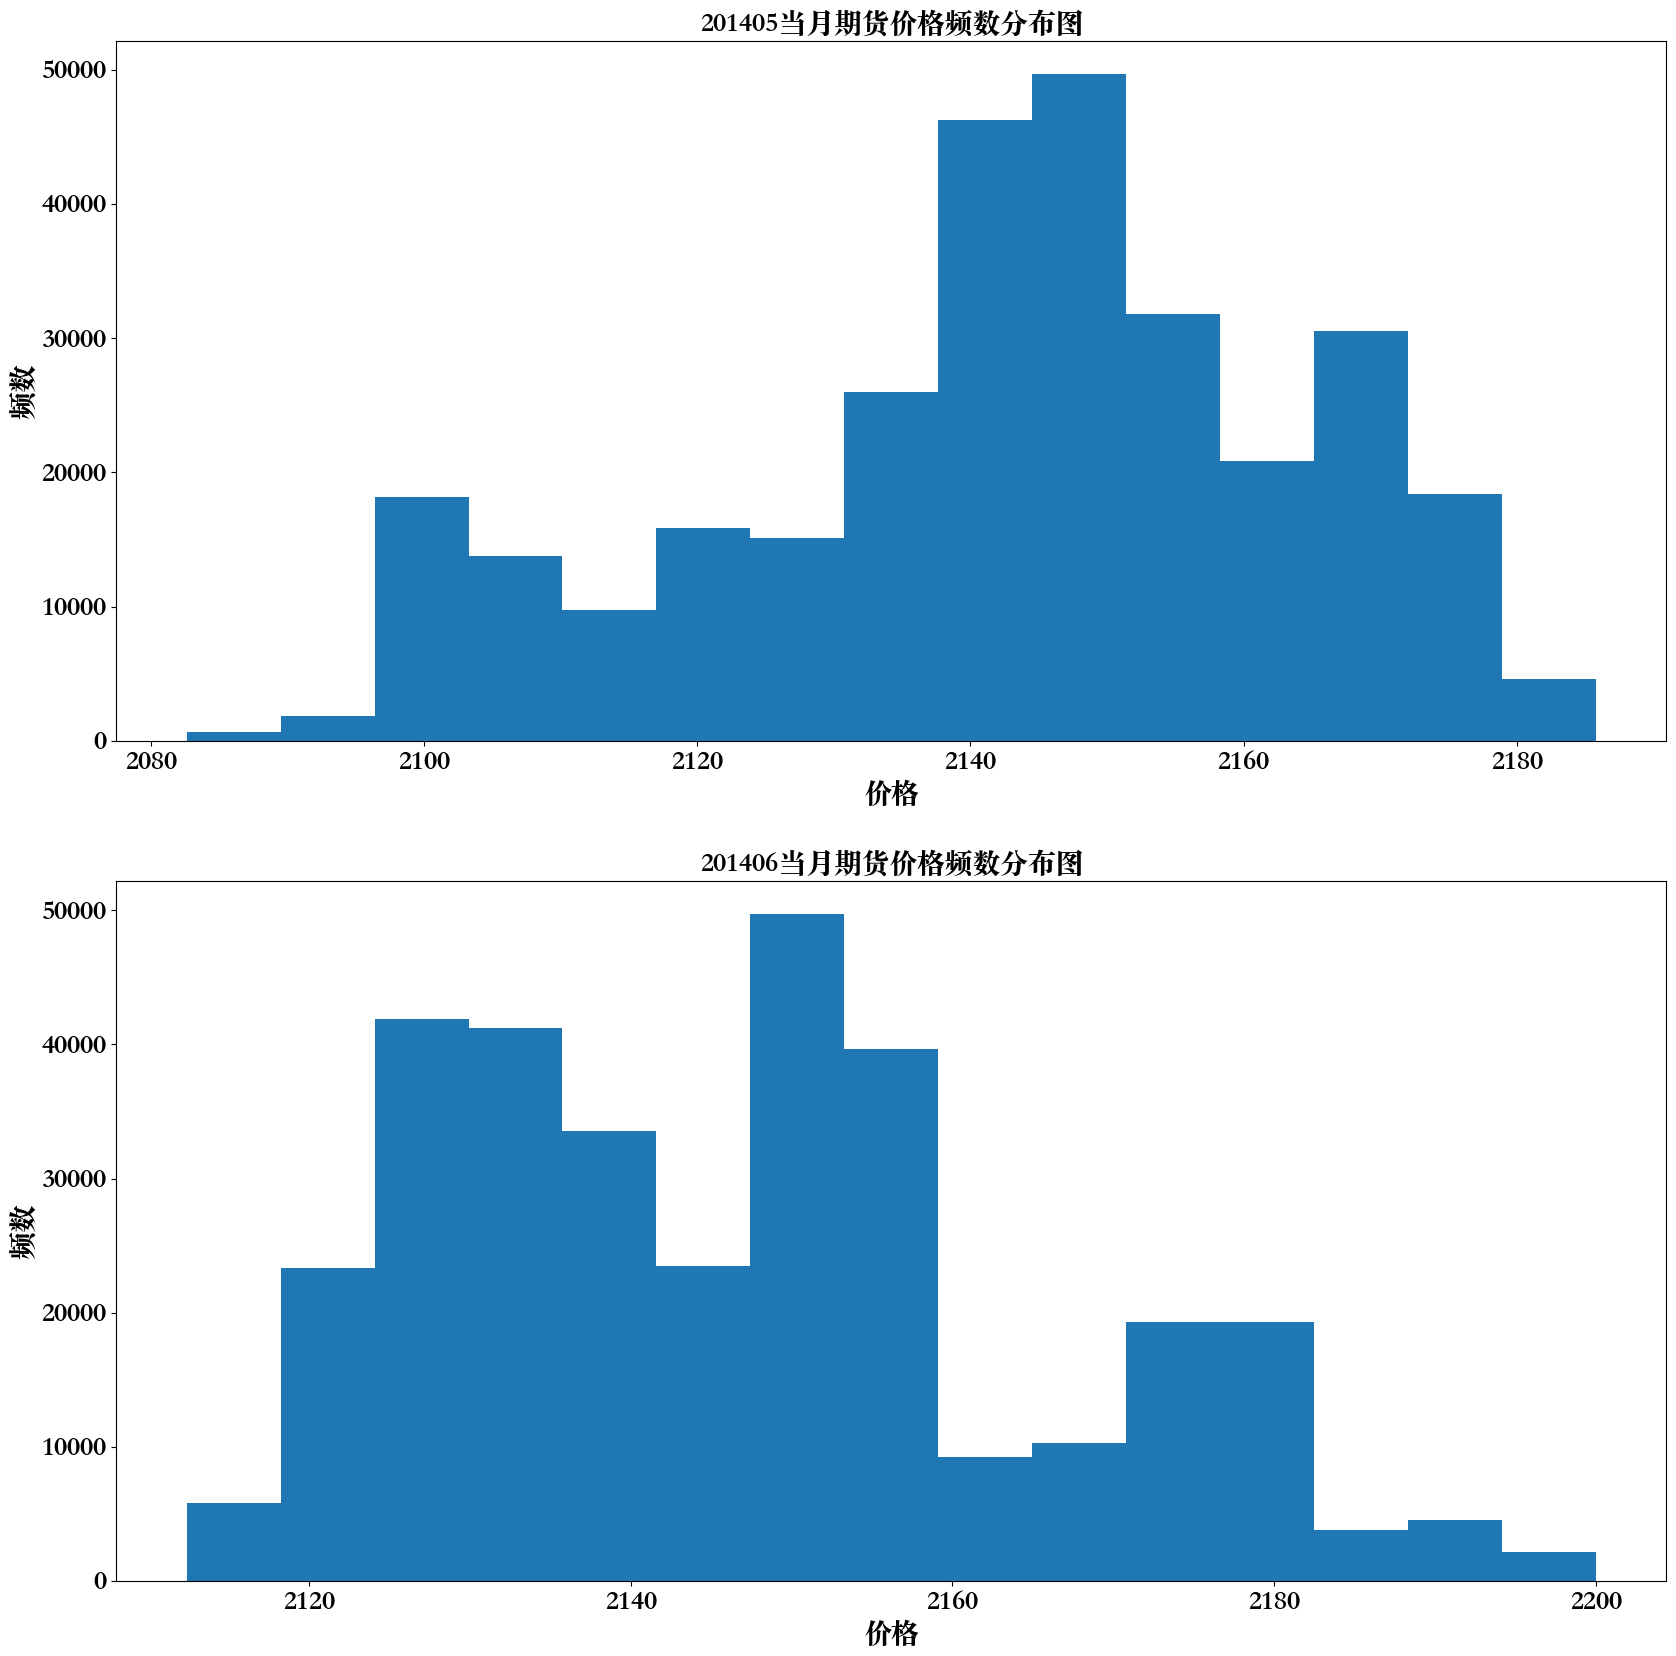

In [7]:
fig, axes = plt.subplots( nrows=2, ncols=1, figsize=(10 * 2, 20) )
fontsize = 20
y = fn1['Price']
axes[0,].set_title('201405当月期货价格频数分布图',fontsize = fontsize)
axes[0,].hist(y, bins=15, density=False,  color='tab:blue') # alpha=0.5,
axes[0,].set_xlabel('价格', fontsize = fontsize)
axes[0,].set_ylabel('频数', fontsize = fontsize)

y = fn2['Price']
axes[1,].set_title('201406当月期货价格频数分布图',fontsize = fontsize)
axes[1,].hist(y, bins=15, density=False,  color='tab:blue') # alpha=0.5,
axes[1,].set_xlabel('价格', fontsize = fontsize)
axes[1,].set_ylabel('频数', fontsize = fontsize)

plt.savefig('../result/Price_histplot.jpg', bbox_inches = 'tight' , dpi=300, pad_inches = 0.0)
plt.show()

价格差分

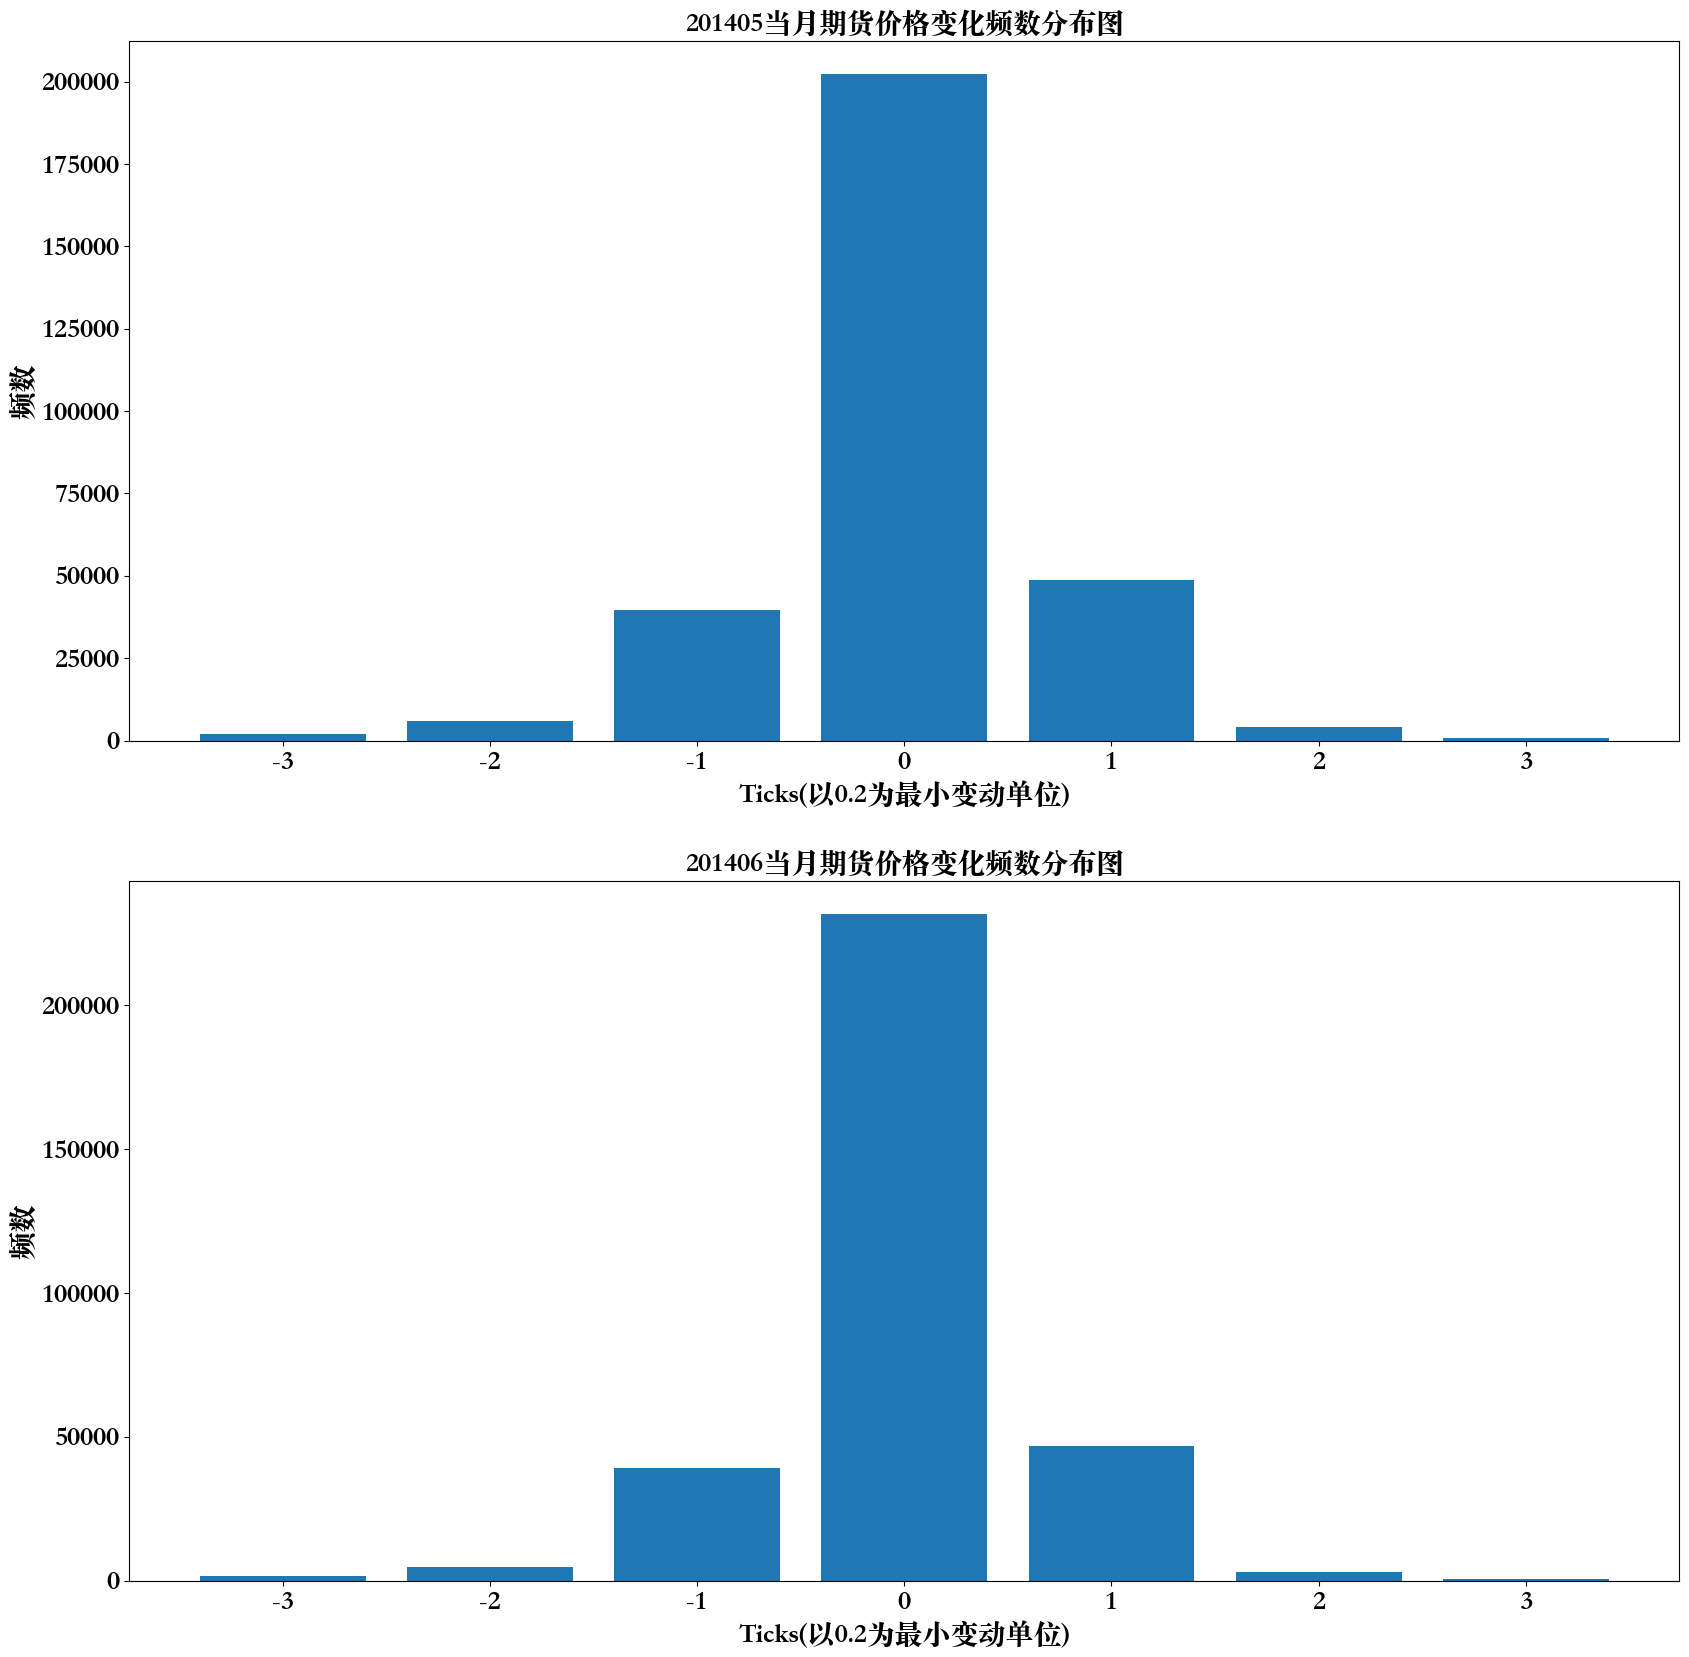

In [8]:
fig, axes = plt.subplots( nrows=2, ncols=1, figsize=(10 * 2, 20) )
fontsize = 20
plot_data = fn1['DeltaTick'].value_counts().sort_index()
hist_x = plot_data.index
hist_y = plot_data.values
axes[0,].set_title('201405当月期货价格变化频数分布图',fontsize = fontsize)
axes[0,].bar(hist_x, hist_y)
axes[0,].set_xlabel('Ticks(以0.2为最小变动单位)',fontsize = fontsize)
axes[0,].set_ylabel('频数',fontsize = fontsize)

plot_data = fn2['DeltaTick'].value_counts().sort_index()
hist_x = plot_data.index
hist_y = plot_data.values
axes[1,].bar(hist_x, hist_y)
axes[1,].set_title('201406当月期货价格变化频数分布图',fontsize = fontsize)
axes[1,].set_xlabel('Ticks(以0.2为最小变动单位)',fontsize = fontsize)
axes[1,].set_ylabel('频数',fontsize = fontsize)

plt.savefig('../result/Price_histplot.jpg', bbox_inches = 'tight' , dpi=300, pad_inches = 0.0)
plt.show()

In [7]:
# dummy predict正确率
print(len(fn1.loc[fn1['DeltaPrice']>0,'DeltaPrice'])/len(fn1['DeltaPrice']))
print(len(fn2.loc[fn2['DeltaPrice']>0,'DeltaPrice'])/len(fn2['DeltaPrice']))
print(len(fn1.loc[fn1['DeltaPrice']>0,'DeltaPrice'])/len(fn1.loc[fn1['DeltaPrice']!=0,'DeltaPrice']))
print(len(fn2.loc[fn2['DeltaPrice']>0,'DeltaPrice'])/len(fn2.loc[fn2['DeltaPrice']!=0,'DeltaPrice']))

0.17631348136033606
0.15320520655096553
0.5297299439281964
0.525086133771769


In [7]:
# 先直接对deltaP分段
# deltaP=fn1['Price'].diff()
# deltaP[deltaP == 0] = np.nan
# abs(deltaP.dropna()).min() # 价格变化最小是0.199
# 
# alpha = [-np.inf,-0.2, 0.2, np.inf] # 左开右闭,这里是三个状态-得到方向预测55%，买卖操作预测56%-开仓0.14
# alpha = [-np.inf,-0.5, -0.2, 0.2, 0.5,np.inf] # 左开右闭,这里是五个状态-方向53%，买卖53%-开仓0.05
# alpha = [-np.inf,-0.5, -0.3, -0.2, 0.2, 0.3, 0.5,np.inf] # 左开右闭,这里是七个状态-方向52%，买卖50%
# alpha = [-np.inf, -0.2, 0, 0.2, np.inf] # 左开右闭,这里是两个状态 # 方向0.58
# alpha = [-np.inf, -0.2, 0, 0.2, np.inf] # 左开右闭,这里是四个状态-得到方向0.57，买卖0.36
# alpha = [-np.inf,-0.5, -0.2, 0, 0.2, 0.5, np.inf] # 左开右闭,这里是六个状态-得到方向0.56，买卖0.44

# 三状态对应解释变量为：['BidAskSpread','StateLag3','VolLag3', 'OpenInt' , 'state', 'Volume', 'BuyatBP','BuyatSP' , 'TotalAmount']

In [8]:
from pandas.api.types import CategoricalDtype
# alpha = [-np.inf,-0.2, 0.2, np.inf] # 左开右闭,这里是三个状态-得到方向预测55%，买卖操作预测56%-开仓0.14
alpha = [-np.inf,-0.3,-0.1,0, 0.3, np.inf] # 左开右闭,这里是五个状态-得到方向预测55%，买卖操作预测56%-开仓0.14

deltaPstate = pd.cut(fn1['DeltaPrice'],alpha,labels = range(len(alpha)-1))
state_type = CategoricalDtype(range(len(alpha)-1), ordered=True)
fn1["state"] = deltaPstate.astype(state_type)
fn1.groupby(['state']).count().iloc[:,0]

state
0      7965
1     39505
2    202336
3     48637
4      4835
Name: date, dtype: int64

In [9]:
# alpha = [-np.inf,-0.2, 0.2, np.inf] # 左开右闭,这里是三个状态-得到方向预测55%，买卖操作预测56%-开仓0.14
alpha = [-np.inf,-0.3,-0.1,0, 0.3, np.inf] # 左开右闭,这里是三个状态-得到方向预测55%，买卖操作预测56%-开仓0.14

deltaPstate = pd.cut(fn2['DeltaPrice'],alpha,labels = range(len(alpha)-1))
state_type = CategoricalDtype(range(len(alpha)-1), ordered=True)
fn2["state"] = deltaPstate.astype(state_type)
fn2.groupby(['state']).count().iloc[:,0]

state
0      6279
1     39071
2    231789
3     46775
4      3366
Name: date, dtype: int64

In [10]:
def DataProcess2(fn):
    fn['FutState'] = fn['state'].shift(-1)
    fn['StateLag3'] = fn['state'].shift(3)
    for date in range(len(set(fn['date']))):
        DropIndex = fn[fn['date'] == date].index[:3]
        fn.loc[DropIndex,'VolLag3'] = np.nan
    fn.dropna(inplace = True)
    fn.index = range(len(fn))
    return fn

fn1 = DataProcess2(fn1)
fn2 = DataProcess2(fn2)
print(len(fn1))
fn1['state'].value_counts().sort_index()

303274


0      7965
1     39505
2    202335
3     48635
4      4834
Name: state, dtype: int64

对新数据进行统计分析

In [11]:
DataDict = {'201405':fn1,'201406':fn2}
filename = ['201405','201406']
sttc_item = ['Low Price','High Price', '%trades at prices', '    >Midquote', '    =Midquote', '    <Midquote','Price change, Zk',\
    '    Mean','    Std.dev.','Time between trades, Delta tk','    Mean','    Std.dev.','Bid ask spread, ABk','    Mean','    Std.dev.',\
        'Buy/sell indicator, IBSk','    Mean','    Std.dev.',]
sttc_fn = pd.DataFrame(columns = pd.Index(filename,name = 'Data'), index = pd.Index(sttc_item, name = 'Statistic'))
for i in range(2):
    # i = 0
    keys = filename[i]
    _ = DataDict[keys]
    sttc_fn.loc['Low Price',keys] = _['Price'].min()
    sttc_fn.loc['High Price',keys] = _['Price'].max()
    sttc_fn.loc['%trades at prices',keys] = np.nan
    sttc_fn.loc['    >Midquote',keys] = (_['BuySellIndicator'] > 1).sum() / len(_)
    sttc_fn.loc['    =Midquote',keys] = (_['BuySellIndicator'] == 1).sum() / len(_)
    sttc_fn.loc['    <Midquote',keys] = (_['BuySellIndicator'] < 1).sum() / len(_)
    sttc_fn.loc['Price change, Zk',keys] = np.nan
    sttc_fn.iloc[7,i] = _['DeltaPrice'].mean()
    sttc_fn.iloc[8,i] = _['DeltaPrice'].std()
    sttc_fn.loc['Time between trades, Delta tk',keys] = np.nan
    sttc_fn.iloc[10,i] = _['DeltaTime'].mean()
    sttc_fn.iloc[11,i] = _['DeltaTime'].std()
    sttc_fn.loc['Bid ask spread, ABk',keys] = np.nan
    sttc_fn.iloc[13,i] = _['BidAskSpread'].mean()
    sttc_fn.iloc[14,i] = _['BidAskSpread'].std()
    sttc_fn.loc['Buy/sell indicator, IBSk',keys] = np.nan
    sttc_fn.iloc[16,i] = _['BuySellIndicator'].mean()
    sttc_fn.iloc[17,i] = _['BuySellIndicator'].std()

sttc_fn.to_csv('../result/data_sttc.csv')
sttc_fn

Data,201405,201406
Statistic,,
Low Price,2082.6,2112.4
High Price,2185.8,2200.0
%trades at prices,NaN,NaN
>Midquote,0.0,0.0
=Midquote,0.900074,0.917623
<Midquote,0.099926,0.082377
"Price change, Zk",NaN,NaN
Mean,0.000018,-0.00002
Std.dev.,0.159894,0.135615


# TODO 2. 自行构造预测需要的解释变量

整合在TODO 1里了

# TODO 3. 实现模型的参数估计

In [15]:
# check_name = 'Open'  # 看看数据是不是日内不变
# fn1[fn1[check_name] !=  fn1[check_name].shift(1)]

In [12]:
# 从构建解释变量到看结果到划分训练测试到估计
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
X_list = ['BidAskSpread','StateLag3','VolLag3', 'OpenInt' , 'state', 'Volume' , 'TotalAmount','BuySellIndicator']
# , 'DeltaPrice'# 海赛不行
# , 'LastClose' # 日内不变，没用
# , 'High', 'TotalVol', 'DeltaTime', 'Low', 'Amount'# 不显著

train_size=0.8
test_size=1-train_size
X_train = fn1.iloc[:int(len(fn1) * train_size),:].loc[:,X_list]
y_train = fn1.iloc[:int(len(fn1) * train_size),:].loc[:,'FutState']
X_test = fn1.iloc[int(len(fn1) * train_size):,:].loc[:,X_list]
y_test = fn1.iloc[int(len(fn1) * train_size):,:].loc[:,'FutState']

scaler = StandardScaler()
# scaler = MinMaxScaler()
df_scaled = scaler.fit(X_train)
X_train = pd.DataFrame(df_scaled.transform(X_train))
X_train.columns = X_list
X_test = pd.DataFrame(df_scaled.transform(X_test))
X_test.columns = X_list

print( '数据集的特征大小为', fn1.shape )
print( '训练集的特征大小为', X_train.shape )
print( '训练集的标签大小为', y_train.shape )
print( '测试集的特征大小为', X_test.shape )
print( '测试集的标签大小为', y_test.shape )

数据集的特征大小为 (303274, 46)
训练集的特征大小为 (242619, 8)
训练集的标签大小为 (242619,)
测试集的特征大小为 (60655, 8)
测试集的标签大小为 (60655,)


In [13]:
mod_prob = OrderedModel(y_train, X_train, distr='probit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 0.958297
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               FutState   Log-Likelihood:            -2.3250e+05
Model:                   OrderedModel   AIC:                         4.650e+05
Method:            Maximum Likelihood   BIC:                         4.652e+05
Date:                Wed, 29 Mar 2023                                         
Time:                        18:38:01                                         
No. Observations:              242619                                         
Df Residuals:                  242607                                         
Df Model:                          12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
BidAskSpread        -0.0915      0.002    -39.118      0.000      -0.096      -0.087
StateLag3            0.0147      0.002      6.419      0.000       0.010       0.019
VolLag3              0.1884      0.054      3.489      0.000       0.083       0.294
OpenInt             -0.0155      0.003     -5.984      0.000      -0.021      -0.010
state               -0.0557      0.002    -24.209      0.000      -0.060      -0.051
Volume               0.0423      0.002     18.155      0.000       0.038       0.047
TotalAmount         -0.1921      0.054     -3.570      0.000      -0.297      -0.087
BuySellIndicator    -0.3411      0.002   -144.068      0.000      -0.346      -0.336
0/1                 -1.9760      0.005   -374.165      0.000      -1.986      -1.966
1/2                 -0.0792      0.005    -14.740      0.000      -0.090      -0.069
2/3                  0.7025      0.002    349.306      0.000       0.699       0.706
3/4                  0.2948      0.005     58.191      0.000       0.285       0.305
====================================================================================
"""

In [14]:
def PreidctStatistics(xt = X_train, yt = y_train):
    print("=" * 75)
    print("最大状态数为",yt.max())
    print("=" * 75)
    predicted = res_prob.model.predict(res_prob.params, exog=np.array(xt))
    PredictState = pd.DataFrame(predicted,index = yt.index).idxmax(axis = 1)
    print("训练集内预测正确率为",(PredictState == yt).sum()/len(yt))
    _ = PredictState
    PredictDirection = _.copy()
    PredictDirection[_ > yt.max()/2] = 'Up'
    PredictDirection[_ < yt.max()/2] = 'Down'
    _ = yt.cat.codes.astype(float)
    y_direction = _.copy()
    y_direction[_ > yt.max()/2] = 'Up'
    y_direction[_ < yt.max()/2] = 'Down'
    print("涨跌方向预测正确率",sum(PredictDirection == y_direction)/len(y_direction))
    _ = yt.cat.codes.astype(float)
    y_BuySell = _.copy()
    y_BuySell[_ >= yt.max()/2+1] = 'Buy'
    y_BuySell[_ <= yt.max()/2-1] = 'Sell'
    y_BuySell[(y_BuySell != 'Sell') * (y_BuySell != 'Buy')] = 'NoOperation'
    _ = PredictState
    PredictBuySell = _.copy()
    PredictBuySell[_ >= yt.max()/2+1] = 'Buy'
    PredictBuySell[_ <= yt.max()/2-1] = 'Sell'
    PredictBuySell[(PredictBuySell != 'Sell') * (PredictBuySell != 'Buy')] = 'NoOperation'
    Buytimes = ((PredictBuySell == 'Buy') * (y_BuySell == 'Buy')).sum()
    SellTimes = ((PredictBuySell == 'Sell') * (y_BuySell == 'Sell')).sum()
    OperateTimes = (PredictBuySell != 'NoOperation').sum()
    print("=" * 75)
    print("开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓")
    print("-" * 75)
    print("开仓操作比率",sum(PredictBuySell != 'NoOperation')/len(PredictBuySell))
    print("每日开仓信号次数",sum(PredictBuySell != 'NoOperation')/len(set(fn1['date']))/train_size)
    print("买卖操作预测正确率",(Buytimes + SellTimes) / OperateTimes)
    print("买卖方向预测正确率",sum(PredictBuySell == y_BuySell)/len(y_direction))
    print("=" * 75)

In [15]:
PreidctStatistics(xt = X_train, yt = y_train)

最大状态数为 4
训练集内预测正确率为 0.6677547924935805
涨跌方向预测正确率 0.670821328914883
开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓
---------------------------------------------------------------------------
开仓操作比率 0.04082120526422086
每日开仓信号次数 619.0
买卖操作预测正确率 0.6011712439418416
买卖方向预测正确率 0.670821328914883


In [16]:
predicted = res_prob.model.predict(res_prob.params, exog=np.array(X_train))
PredictState = pd.DataFrame(predicted,index = y_train.index).idxmax(axis = 1)
pd.DataFrame({'观测价格状态':y_train.value_counts(),'预测价格状态':PredictState.value_counts()})

,观测价格状态,预测价格状态
0,6857,2
1,31893,1
2,160122,232715
3,39473,9900
4,4274,1


In [17]:
print( '数据集的特征大小为', fn1.shape )
print( '训练集的特征大小为', X_train.shape )
print( '训练集的标签大小为', y_train.shape )
print( '测试集的特征大小为', X_test.shape )
print( '测试集的标签大小为', y_test.shape )

数据集的特征大小为 (303274, 46)
训练集的特征大小为 (242619, 8)
训练集的标签大小为 (242619,)
测试集的特征大小为 (60655, 8)
测试集的标签大小为 (60655,)


# TODO 4. 实现预测并评估预测效果。

In [18]:
PreidctStatistics(xt = X_test, yt = y_test)

最大状态数为 4
训练集内预测正确率为 0.7029428736295441
涨跌方向预测正确率 0.7051191163135768
开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓
---------------------------------------------------------------------------
开仓操作比率 0.031637952353474566
每日开仓信号次数 119.9375
买卖操作预测正确率 0.6190724335591454
买卖方向预测正确率 0.7051191163135768


# TODO 4.对fn2进行同样操作

In [20]:
# 从构建解释变量到看结果到划分训练测试到估计
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
X_list = ['BidAskSpread','StateLag3','VolLag3', 'OpenInt' , 'state', 'Volume' , 'TotalAmount','BuySellIndicator']
# , 'DeltaPrice'# 海赛不行
# , 'LastClose' # 日内不变，没用
# , 'High', 'TotalVol', 'DeltaTime', 'Low', 'Amount'# 不显著

train_size=0.8
test_size=1-train_size
X_train = fn1.iloc[:int(len(fn2) * train_size),:].loc[:,X_list]
y_train = fn1.iloc[:int(len(fn2) * train_size),:].loc[:,'FutState']
X_test = fn1.iloc[int(len(fn2) * train_size):,:].loc[:,X_list]
y_test = fn1.iloc[int(len(fn2) * train_size):,:].loc[:,'FutState']

scaler = StandardScaler()
# scaler = MinMaxScaler()
df_scaled = scaler.fit(X_train)
X_train = pd.DataFrame(df_scaled.transform(X_train))
X_train.columns = X_list
X_test = pd.DataFrame(df_scaled.transform(X_test))
X_test.columns = X_list

print( '数据集的特征大小为', fn1.shape )
print( '训练集的特征大小为', X_train.shape )
print( '训练集的标签大小为', y_train.shape )
print( '测试集的特征大小为', X_test.shape )
print( '测试集的标签大小为', y_test.shape )

mod_prob = OrderedModel(y_train, X_train, distr='probit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

数据集的特征大小为 (303274, 46)
训练集的特征大小为 (261820, 8)
训练集的标签大小为 (261820,)
测试集的特征大小为 (41454, 8)
测试集的标签大小为 (41454,)
Optimization terminated successfully.
         Current function value: 0.946655
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               FutState   Log-Likelihood:            -2.4785e+05
Model:                   OrderedModel   AIC:                         4.957e+05
Method:            Maximum Likelihood   BIC:                         4.959e+05
Date:                Wed, 29 Mar 2023                                         
Time:                        10:00:36                                         
No. Observations:              261820                                         
Df Residuals:                  261808                                         
Df Model:                          12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
BidAskSpread        -0.0923      0.002    -40.921      0.000      -0.097      -0.088
StateLag3            0.0134      0.002      6.090      0.000       0.009       0.018
VolLag3              0.1374      0.052      2.667      0.008       0.036       0.238
OpenInt             -0.0143      0.002     -5.765      0.000      -0.019      -0.009
state               -0.0571      0.002    -25.757      0.000      -0.061      -0.053
Volume               0.0419      0.002     18.682      0.000       0.037       0.046
TotalAmount         -0.1408      0.051     -2.741      0.006      -0.241      -0.040
BuySellIndicator    -0.3402      0.002   -149.043      0.000      -0.345      -0.336
0/1                 -1.9944      0.005   -386.616      0.000      -2.004      -1.984
1/2                 -0.0696      0.005    -13.379      0.000      -0.080      -0.059
2/3                  0.7133      0.002    370.127      0.000       0.710       0.717
3/4                  0.3038      0.005     61.557      0.000       0.294       0.313
====================================================================================
"""

In [21]:
PreidctStatistics(xt = X_train, yt = y_train)

最大状态数为 4
训练集内预测正确率为 0.6729661599572225
涨跌方向预测正确率 0.6758689175769613
开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓
---------------------------------------------------------------------------
开仓操作比率 0.039813612405469406
每日开仓信号次数 651.5
买卖操作预测正确率 0.6011128165771297
买卖方向预测正确率 0.6758689175769613


In [22]:
predicted = res_prob.model.predict(res_prob.params, exog=np.array(X_train))
PredictState = pd.DataFrame(predicted,index = y_train.index).idxmax(axis = 1)
pd.DataFrame({'观测价格状态':y_train.value_counts(),'预测价格状态':PredictState.value_counts()}).sort_index()

,观测价格状态,预测价格状态
0,7093,2
1,34113,3
2,174202,251396
3,42041,10418
4,4371,1


In [23]:
PreidctStatistics(xt = X_test, yt = y_test)

最大状态数为 4
训练集内预测正确率为 0.6871230761808269
涨跌方向预测正确率 0.6897524967433782
开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓
---------------------------------------------------------------------------
开仓操作比率 0.03546099290780142
每日开仓信号次数 91.875
买卖操作预测正确率 0.6285714285714286
买卖方向预测正确率 0.6897524967433782


# TODO 5. 构造简单的交易策略，分析策略损益（PnL）的统计特征，特别注意评估模型的稳健性、是否过拟合等问题。

In [69]:
price_data = pd.concat([fn1[['Time','Price']],fn2[['Time','Price']]],axis=0)
price_data = price_data.set_index('Time')
price_data.index = pd.to_datetime(price_data.index)
price_data.columns = ['ClosePrice']
# price_data = price_data.fillna()
price_data.to_csv('../dataset/price.csv')

In [74]:
weight = price_data.copy()
weight['Time'] = weight.index
weight_open = weight.resample('d').first().dropna()
weight_close = weight.resample('d').last().dropna()
weight_open['weight'] = 1
weight_close['weight'] = 0
weight = pd.concat([weight_open,weight_close],axis=0)
weight.index = weight['Time']
weight = weight[['weight']]
weight.index.name = None
weight = weight.sort_index()
weight.to_csv('../result/strategy/weight.csv')

2014-05-05已完成回测
2014-05-06已完成回测
2014-05-07已完成回测
2014-05-08已完成回测
2014-05-09已完成回测
2014-05-12已完成回测
2014-05-13已完成回测
2014-05-14已完成回测
2014-05-15已完成回测
2014-05-16已完成回测
2014-05-19已完成回测
2014-05-20已完成回测
2014-05-21已完成回测
2014-05-22已完成回测
2014-05-23已完成回测
2014-05-26已完成回测
2014-05-27已完成回测
2014-05-28已完成回测
2014-05-29已完成回测
2014-05-30已完成回测
2014-06-03已完成回测
2014-06-04已完成回测
2014-06-05已完成回测
2014-06-06已完成回测
2014-06-09已完成回测
2014-06-10已完成回测
2014-06-11已完成回测
2014-06-12已完成回测
2014-06-13已完成回测
2014-06-16已完成回测
2014-06-17已完成回测
2014-06-18已完成回测
2014-06-19已完成回测
2014-06-20已完成回测
2014-06-23已完成回测
2014-06-24已完成回测
2014-06-25已完成回测
2014-06-26已完成回测
2014-06-27已完成回测


<Figure size 1200x600 with 0 Axes>

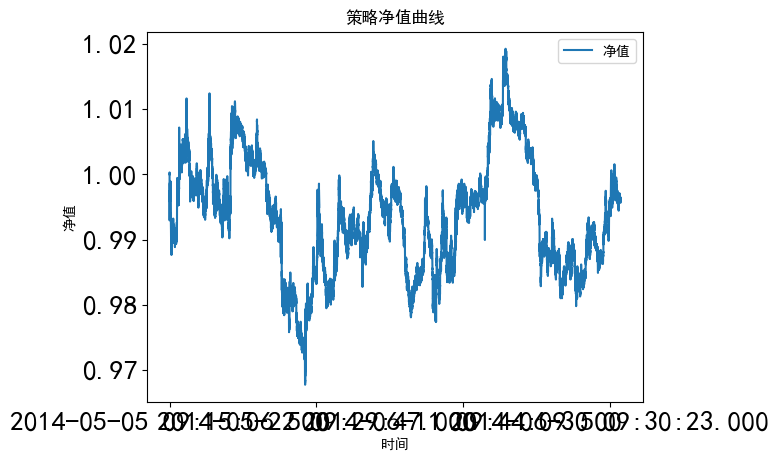

{'策略详情':                          ClosePrice   现金
 2014-05-05 09:15:06.500    1.000000  0.0
 2014-05-05 09:15:08.000    1.000093  0.0
 2014-05-05 09:15:08.500    1.000279  0.0
 2014-05-05 09:15:10.500    1.000000  0.0
 2014-05-05 09:15:11.000    1.000000  0.0
 ...                             ...  ...
 2014-06-30 15:14:54.500    0.996265  0.0
 2014-06-30 15:14:56.000    0.996358  0.0
 2014-06-30 15:14:57.000    0.996265  0.0
 2014-06-30 15:14:57.500    0.996265  0.0
 2014-06-30 15:14:58.500    0.996265  0.0
 
 [614763 rows x 2 columns],
 '策略净值':                                净值
 2014-05-05 09:15:06.500  1.000000
 2014-05-05 09:15:08.000  1.000093
 2014-05-05 09:15:08.500  1.000279
 2014-05-05 09:15:10.500  1.000000
 2014-05-05 09:15:11.000  1.000000
 ...                           ...
 2014-06-30 15:14:54.500  0.996265
 2014-06-30 15:14:56.000  0.996358
 2014-06-30 15:14:57.000  0.996265
 2014-06-30 15:14:57.500  0.996265
 2014-06-30 15:14:58.500  0.996265
 
 [614763 rows x 1 columns],


In [80]:
import backtest_future
param = backtest_future.init_param()
param['start_time'] = '2014-06-01'  # 回测开始时间
param['end_time'] = '2014-07-01'  # 回测结束时间
param['trade_fee'] = True  # 是否考虑交易费用
param['control_loss'] = False  # 是否止损
param['max_loss'] = 0.20  # 最大损失
param['time_loss'] = 90  # 止损原则
param['price_type'] = 'close'  # 价格类型
param['price'] = '../dataset/price.csv'  # 主力期货价格数据
param['weight'] = '../result/strategy/weight.csv'  # 策略权重
param['plot_nav'] = True  # 是否画净值图
param['write_to_excel'] = True  # 是否写入结果
param['plot_show'] = True  # 是否展示画图
param['pic_save_path'] = '../result/strategy/净值曲线.png'  # 存放图片路径
param['excel_save_path'] = '../result/strategy/策略结果.xlsx'  # 存放结果路径
backtest_future.backtest(param=param)

# 草稿备份

变量选择代码

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler
X_list = ['DeltaTime', 'BidAskSpread','StateLag3','VolLag3','Volume', 'Amount', 'OpenInt' , 'TotalAmount', 'High', 'state']
# , 'DeltaPrice'# 海赛不行
# , 'LastClose' # 日内不变，没用
# , 'TotalVol', 'Low'# 不显著

train_size=0.8
X_train = fn1Fit.iloc[:int(len(fn1Fit) * train_size),:].loc[:,X_list]
y_train = fn1Fit.iloc[:int(len(fn1Fit) * train_size),:].loc[:,'FutState']
X_test = fn1Fit.iloc[int(len(fn1Fit) * train_size):,:].loc[:,X_list]
y_test = fn1Fit.iloc[int(len(fn1Fit) * train_size):,:].loc[:,'FutState']

scaler = StandardScaler()
df_scaled = scaler.fit(X_train)
X_train = pd.DataFrame(df_scaled.transform(X_train))
X_train.columns = X_list
X_test = pd.DataFrame(df_scaled.transform(X_test))
X_test.columns = X_list
mod_prob = OrderedModel(y_train, X_train, distr='probit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

评测指标

In [159]:
# 单数状态预测评测指标
print("=" * 75)
print("最大状态数为",y_train.max())
print("=" * 75)
predicted = res_prob.model.predict(res_prob.params, exog=np.array(X_train))
PredictState = pd.DataFrame(predicted,index = y_train.index).idxmax(axis = 1)
print("训练集内预测正确率为",(PredictState == y_train).sum()/len(y_train))
_ = PredictState
PredictDirection = _.copy()
PredictDirection[_ > y_train.max()/2] = 'Up'
PredictDirection[_ < y_train.max()/2] = 'Down'
_ = y_train.cat.codes.astype(float)
y_direction = _.copy()
y_direction[_ > y_train.max()/2] = 'Up'
y_direction[_ < y_train.max()/2] = 'Down'
print("涨跌方向预测正确率",sum(PredictDirection == y_direction)/len(y_direction))
_ = y_train.cat.codes.astype(float)
y_BuySell = _.copy()
y_BuySell[_ >= y_train.max()/2+1] = 'Buy'
y_BuySell[_ <= y_train.max()/2-1] = 'Sell'
y_BuySell[(y_BuySell != 'Sell') * (y_BuySell != 'Buy')] = 'NoOperation'
_ = PredictState
PredictBuySell = _.copy()
PredictBuySell[_ >= y_train.max()/2+1] = 'Buy'
PredictBuySell[_ <= y_train.max()/2-1] = 'Sell'
PredictBuySell[(PredictBuySell != 'Sell') * (PredictBuySell != 'Buy')] = 'NoOperation'
Buytimes = ((PredictBuySell == 'Buy') * (y_BuySell == 'Buy')).sum()
SellTimes = ((PredictBuySell == 'Sell') * (y_BuySell == 'Sell')).sum()
OperateTimes = (PredictBuySell != 'NoOperation').sum()
print("=" * 75)
print("开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓")
print("-" * 75)
print("开仓操作比率",sum(PredictBuySell != 'NoOperation')/len(PredictBuySell))
print("每日开仓信号次数",sum(PredictBuySell != 'NoOperation')/len(set(fn1['date']))/train_size)
print("买卖方向预测正确率",(Buytimes + SellTimes) / OperateTimes)
print("=" * 75)

最大状态数为 2
训练集内预测正确率为 0.5507144007831766
涨跌方向预测正确率 0.5507144007831766
开仓操作定义为，若处于中间状态则不开仓，对小于中间状态的开空仓，对大于中间状态的开多仓
---------------------------------------------------------------------------
开仓操作比率 0.1313183885398466
每日开仓操作次数 662.3125
买卖方向预测正确率 0.5623289610267057


In [ ]:
# 双数状态预测评测指标
predicted = res_prob.model.predict(res_prob.params, exog=np.array(X_train))
PredictState = pd.DataFrame(predicted,index = y_train.index).idxmax(axis = 1)
print("训练集内预测正确率为",(PredictState == y_train).sum()/len(y_train))
PredictDirection = PredictState.copy()
PredictDirection[PredictDirection > y_train.max()/2] = 'Up'
PredictDirection[PredictDirection != 'Up'] = 'Down'
y_direction = y_train.cat.codes.astype(float).copy()
y_direction[y_direction > int(y_train.max()/2)] = 'Up'
y_direction[y_direction != 'Up'] = 'Down'
print("涨跌方向预测正确率",sum(PredictDirection == y_direction)/len(y_direction))
y_HighLow = y_train.cat.codes.astype(float).copy()
y_HighLow[y_HighLow > int(y_train.max()/2)+1] = 'High'
_ = ((y_HighLow[y_HighLow != 'High'] < int(y_train.max()/2)) * 1)
y_HighLow[_[_ == 1].index] = 'Low'
y_HighLow[(y_HighLow != 'Low') * (y_HighLow != 'High')] = 'NoOperation'
PredictHighLow = PredictState.copy()
PredictHighLow[PredictHighLow > int(y_train.max()/2)+1] = 'High'
_ = ((PredictHighLow[PredictHighLow != 'High'] < int(y_train.max()/2)) * 1)
PredictHighLow[_[_ == 1].index] = 'Low'
PredictHighLow[(PredictHighLow != 'Low') * (PredictHighLow != 'High')] = 'NoOperation'
print("-" * 20)
print("开仓操作定义为，若处于2,3状态则不开仓，对0,1开空仓，对3,4开多仓")
print("-" * 20)
print("开仓操作比率",sum(PredictHighLow != 'NoOperation')/len(y_HighLow))
print("买卖方向预测正确率",sum(PredictHighLow == y_HighLow)/len(y_HighLow))

分块画图（但建议用ax.plot）

In [ ]:
# import matplotlib.pyplot as plt
 
# plt.figure(figsize=[24,24])
 
# plt.subplot(221)
# plt.hist(fn1['Price'],bins=20,color='b')
# plt.xlabel('Weight')
# plt.title('Distribution by Weight')
 
# plt.subplot(222)
# plt.hist(fn1['DeltaPrice'],bins=20,color='r')
# plt.xlabel('Diamond Depth')
# plt.title('Distribution by Depth')
 
# plt.subplot(223)
# plt.hist(fn1['DeltaTime'],bins=20,color='g')
# plt.xlabel('Price')
# plt.title('Distribution by Price')
 
# plt.subplot(224)
# plt.hist(fn1['Price'],bins=20,color='m')
# plt.xlabel('Volume')
# plt.title('Distribution by Volume')